In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
sns.set()
from results import load

#constants
experiment_phase = {'p0':60000, 'p1':60000, 'p2':180000}
experiment_phase_labels = [*experiment_phase]

# Reading the results

In [22]:
#config
experiment_name = "full"
providers = ["aws","ibm","gcf","azure"] 
num_repetitions = 1
configs = [ "0,0,1","0,0,0.5","0,0,2","60,60,0.5","60,60,1"]

all = load(experiment_name, providers,configs,num_repetitions,True)
all.columns
all.to_csv("results/full.csv")

b'Skipping line 4058: expected 15 fields, saw 20\n'


In [51]:
#sns.set_palette(sns.color_palette("Paired"))

palette = sns.color_palette().as_hex()
style = {
    "aws":{
        "name":"AWS",
        "color":palette[0]
    },
    "ibm":{
        "name":"ICF",
        "color":palette[1]
    },
    "gcf":{
        "name":"GCF",
        "color":palette[2]
    },
    "azure":{
        "name":"MAF",
        "color":palette[3]
    },
}


### Cost per Request

In [7]:
def costPerSecond(ax,all,provider,workload):
    data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
    data = data.copy()
    
    #goup by second
    data["EStart_1s"] = round(data["EStart"]/1000)
    #sum up cost
    data = data.groupby(["EStart_1s"])["ECost"].sum().reset_index(name="ECost")
    #plot
    ax.scatter(x="EStart_1s",y="ECost",data=data,label=provider,color=style[provider]["color"],alpha=0.8)
   
    
    ax.set_xlim([0,300])
    ax.set_xlabel("time [s]")
    ax.set_ylabel(r"cost [$\mu$\$]")
    
    #highlight phases
    ax.axvline(60,alpha=0.5)
    ax.axvline(120,alpha=0.5)
    ax.set_xticks(ticks=[30,90,200])
    ax.set_xticklabels(["p0","p1","p2"])
    
    #title
    ax.set_title("{} - Cost per Second".format(style[provider]["name"]))
    
    #legend
    ax.legend()

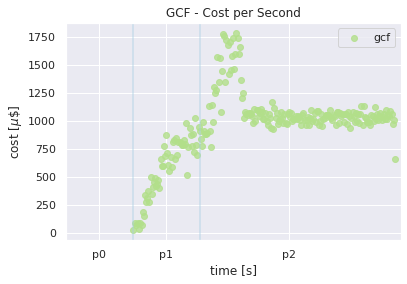

In [8]:

fig,ax = plt.subplots()
costPerSecond(ax,all,"gcf","0,0,1")

### Throughput

In [20]:
def thruputPerSecond(ax,all,provider,workload):
    data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
    data = data.copy()

    #goup by second
    data["EStart_1s"] = round(data["EStart"]/1000)
    #sum up cost
    data = data.groupby(["EStart_1s","CNew"])["RId"].count().reset_index(name="throughput")
    #plot
    ax.scatter(x="EStart_1s",y="throughput",data=data,label=provider,c=style[provider]["color"],alpha=0.8)


    ax.set_xlim([0,300])
    ax.set_xlabel("time [s]")
    ax.set_ylabel(r"request [#]")

    #highlight phases
    ax.axvline(60,alpha=0.5)
    ax.axvline(120,alpha=0.5)
    ax.set_xticks(ticks=[30,90,200])
    ax.set_xticklabels(["p0","p1","p2"])

    #title
    ax.set_title("{} - Throughput per Second".format(style[provider]["name"]))

    #legend
    ax.legend()


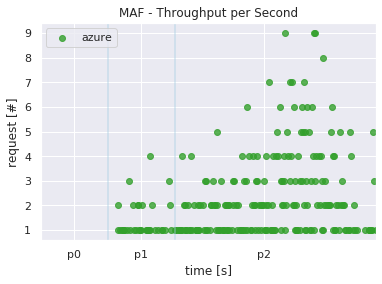

In [21]:
fig,ax = plt.subplots()
thruputPerSecond(ax,all,"azure","0,0,1")

## Failed Request

In [24]:
def plotFailedRequestPerSecond(ax,all,provider,workload):
    data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
    data = data.copy()
    data["RStart_1s"] = round(data["RStart"]/1000)
    #sum up cost
    data = data.groupby(["RStart_1s"])["RFailed"].sum().reset_index(name="RFailed")

    ax.axvline(60,alpha=0.5)
    ax.axvline(120,alpha=0.5)

    ax.scatter(x="RStart_1s", y='RFailed', data=data, color="indianred",label="{}".format(style[provider]["name"])) 

    ax.set_xlim([0,300])
    ax.set_xlabel("time [s]")
    ax.set_ylabel(r"failed requests [#]")

    #highlight phases

    ax.set_xticks(ticks=[30,90,200])
    ax.set_xticklabels(["p0","p1","p2"])

    #title
    ax.set_title("{} - Failed Request per Second".format(style[provider]["name"]))

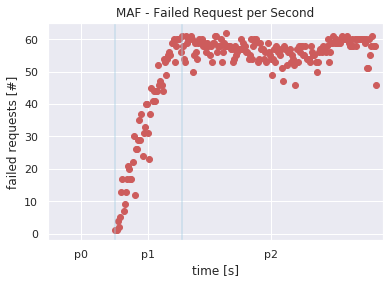

In [25]:
fig,ax = plt.subplots()
plotFailedRequestPerSecond(ax,all,"azure","0,0,1")

## Request Latency

In [48]:
def plotRequestResponseViolin(ax,all,provider,workload):
    ax.set_title("{} Request Response Latency ".format(style[provider]["name"]))
    data = all[(all['Provider'] == provider) & (all["WL"] == workload)]
    data = data[data["RLat"].notna()]
    data = data[data["RCode"] != 429] #filters filed requests e.g. azure
    data = data[data["Phase"].isin(["p1","p2"])]
    inner = None
    sns.violinplot(x='Provider', y='RLat', data=data, hue='Phase', scale='area', split=True, inner=inner ,cut=0,ax=ax)
    ax.set_yscale('log')

    ax.set_xlabel("")
    ax.set_ylabel(r"Request Response Latency [log(s)]")

    #highlight phases

    ax.set_xticklabels([""])

    delta = 0.02
    delta = 0.02

    #code for gap between violin halves, from stackoverflow.com/questions/43357274/
    for ii, item in enumerate(ax.collections):
    # axis contains PolyCollections and PathCollections
        if isinstance(item, matplotlib.collections.PolyCollection):
        # get path
            path, = item.get_paths()
            vertices = path.vertices

        # shift x-coordinates of path
            if not inner:
                if ii % 2: # -> to right
                    vertices[:,0] += delta
                else: # -> to left
                    vertices[:,0] -= delta
            else: # inner='box' adds another type of PollyCollection
                if ii % 3 == 0:
                    vertices[:,0] -= delta
                elif ii % 3 == 1:
                    vertices[:,0] += delta
                else: # ii % 3 = 2
                    pass

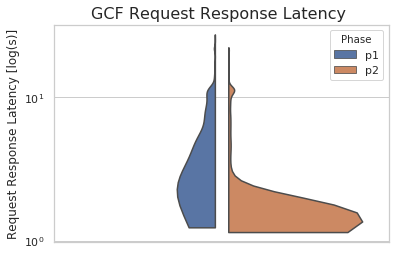

In [39]:
fig,ax = plt.subplots()
sns.set(style="whitegrid")
plotRequestResponseViolin(ax,all,"gcf","0,0,1")

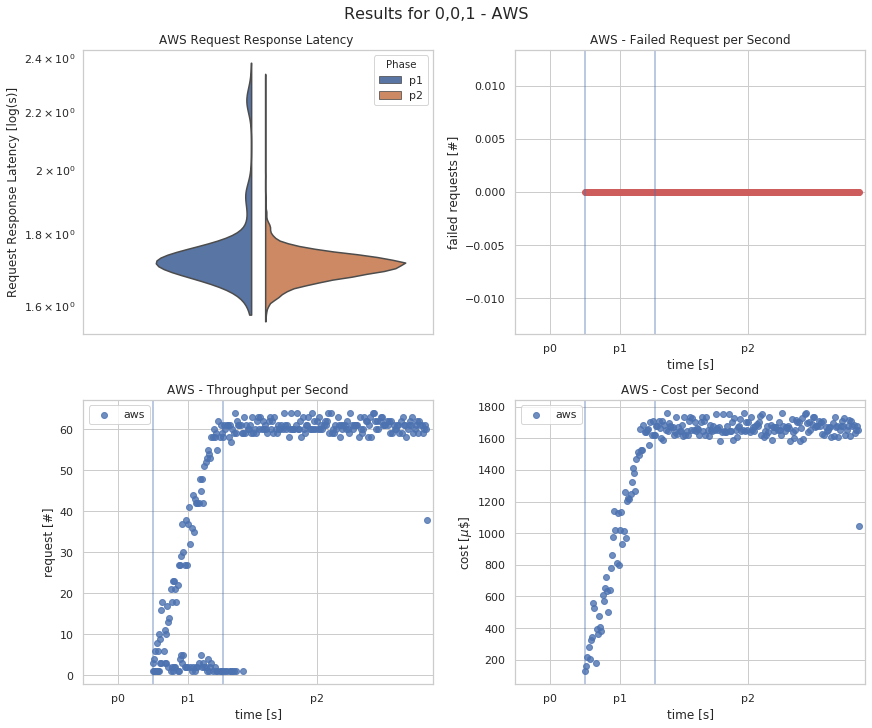

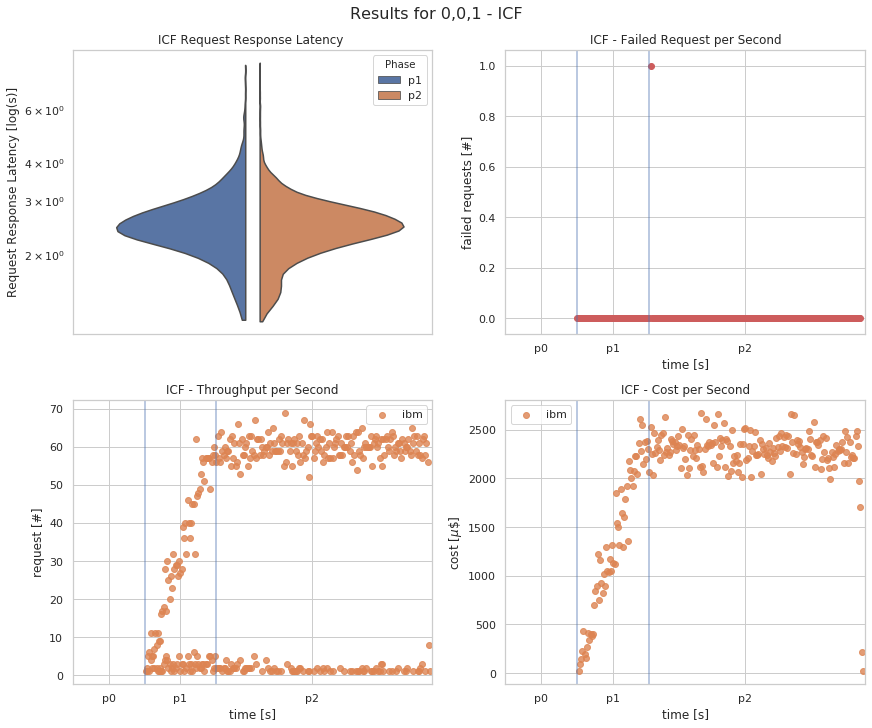

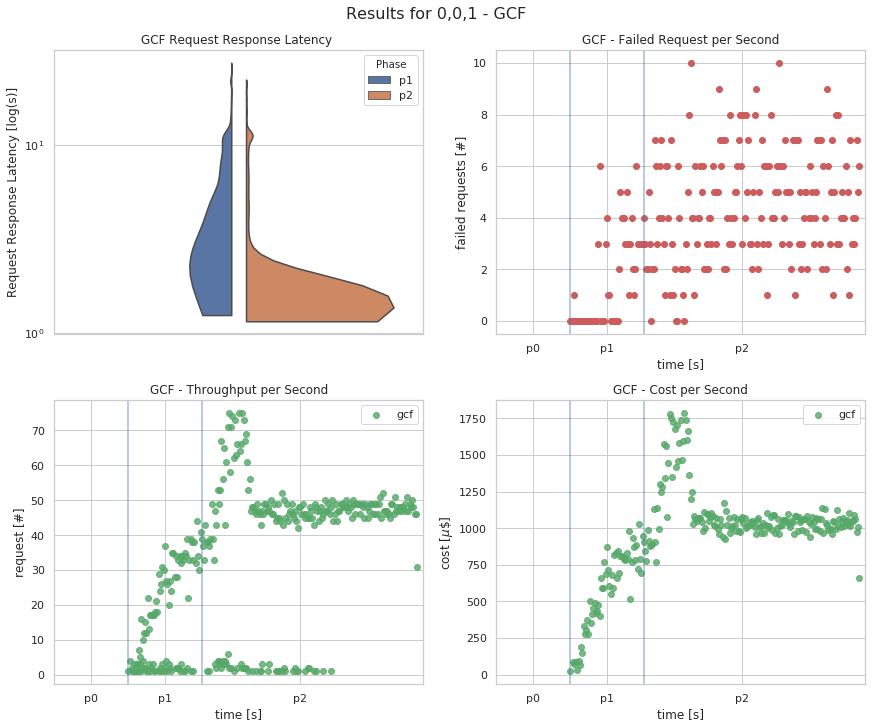

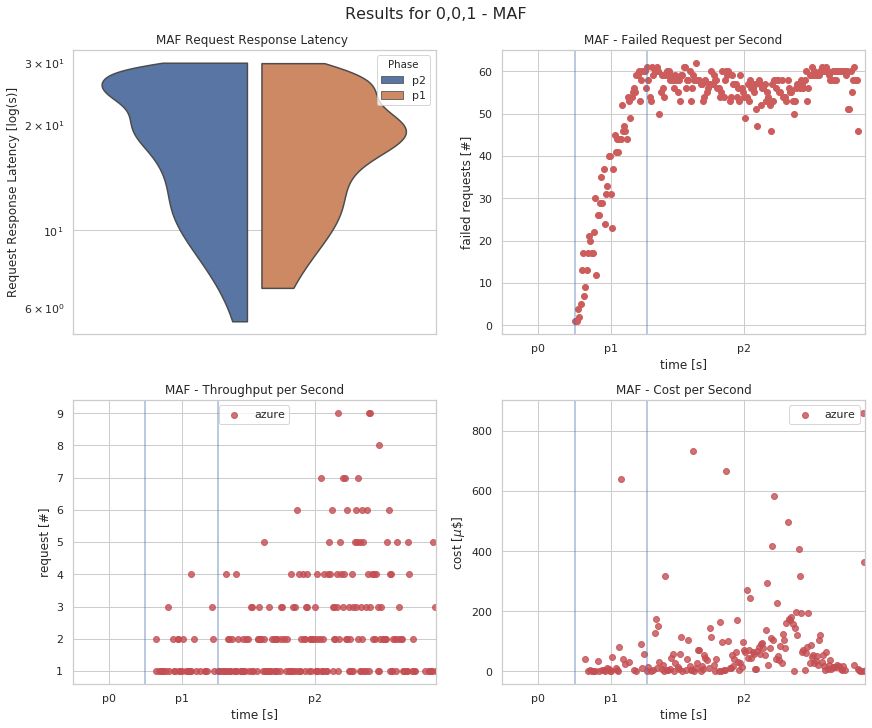

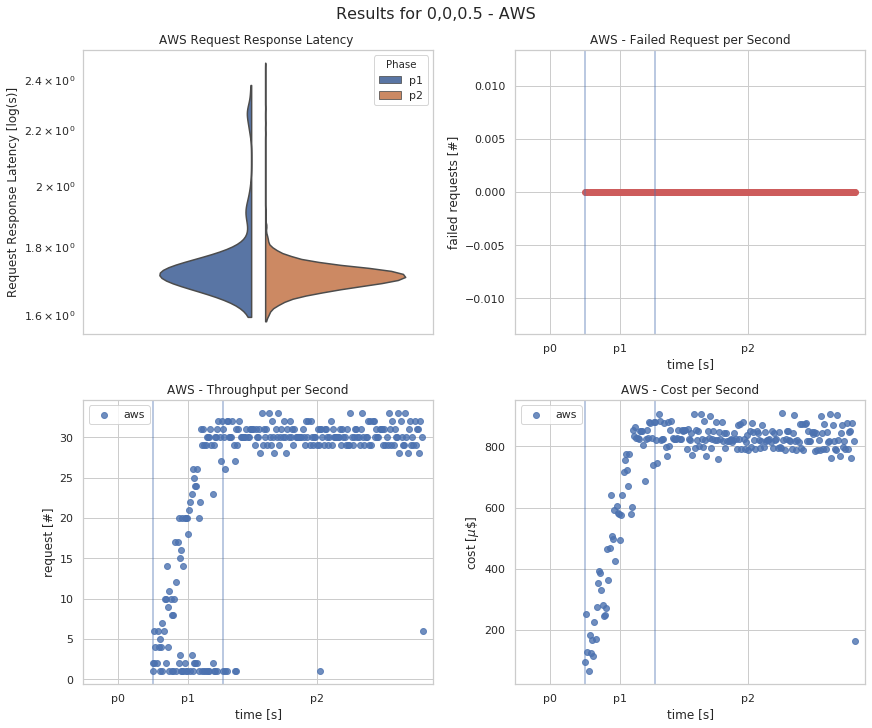

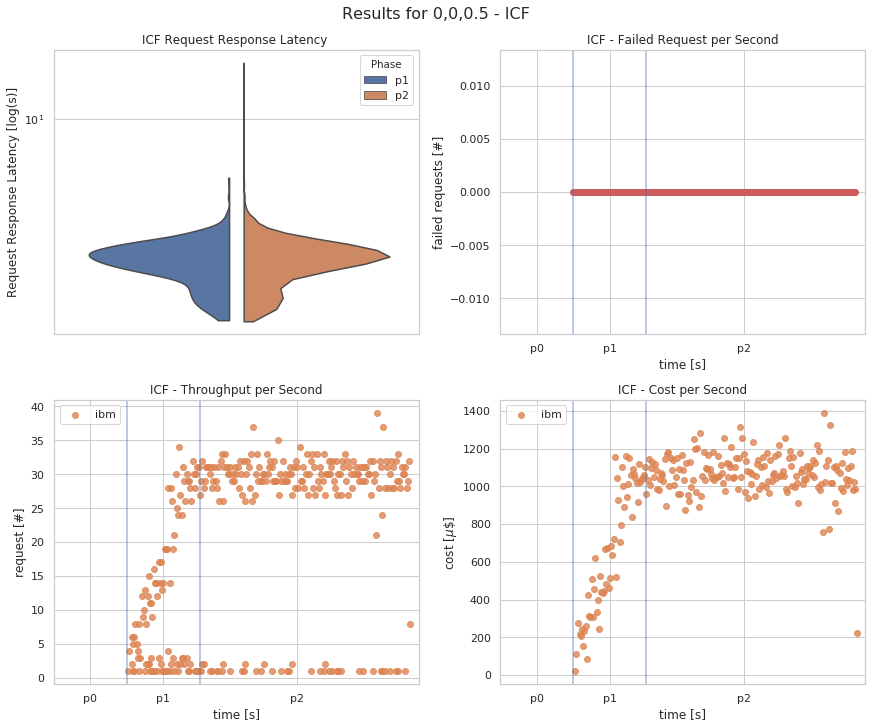

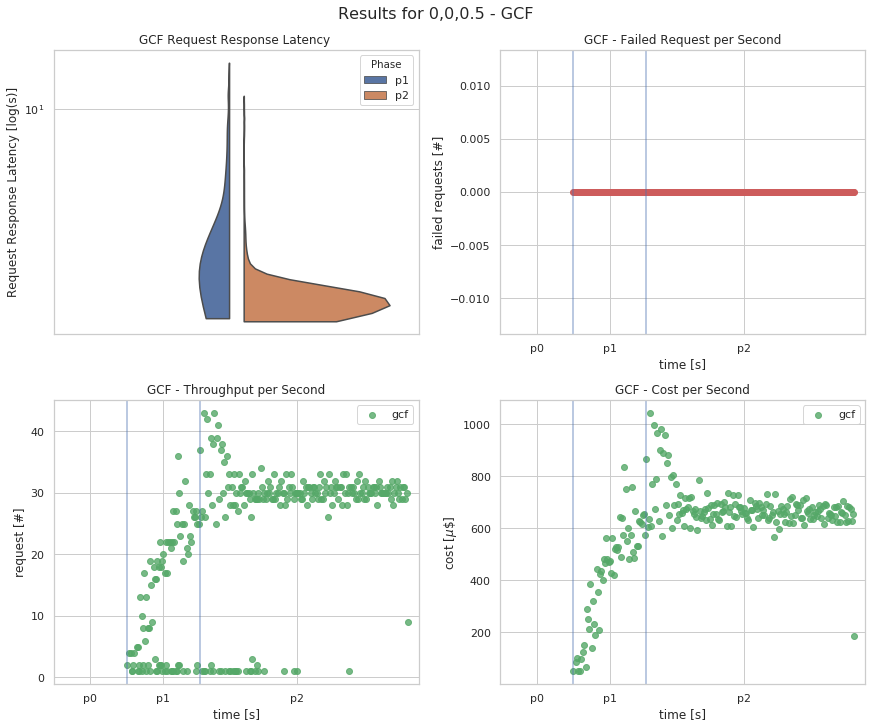

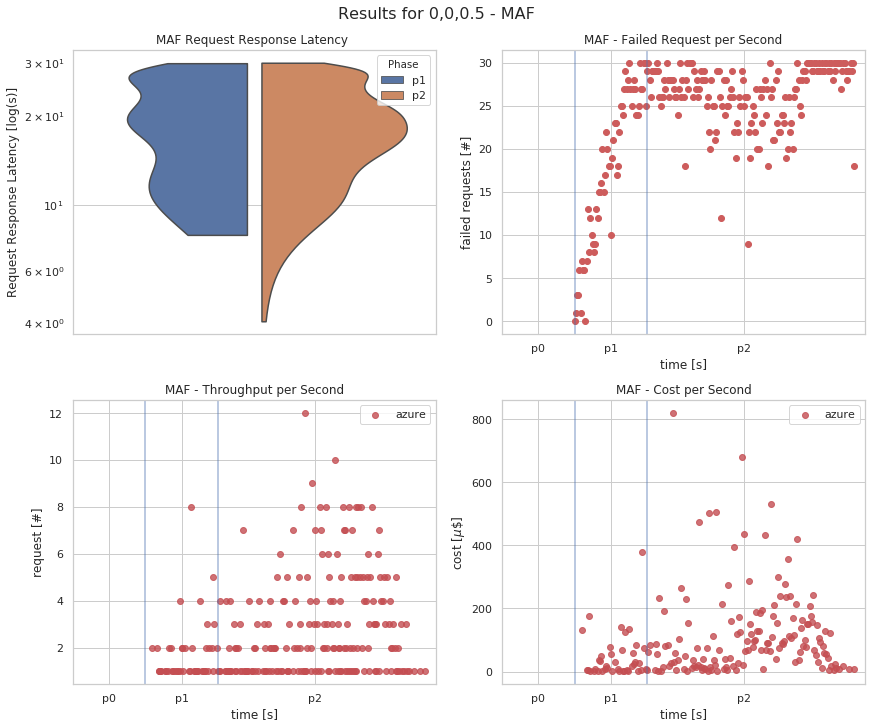

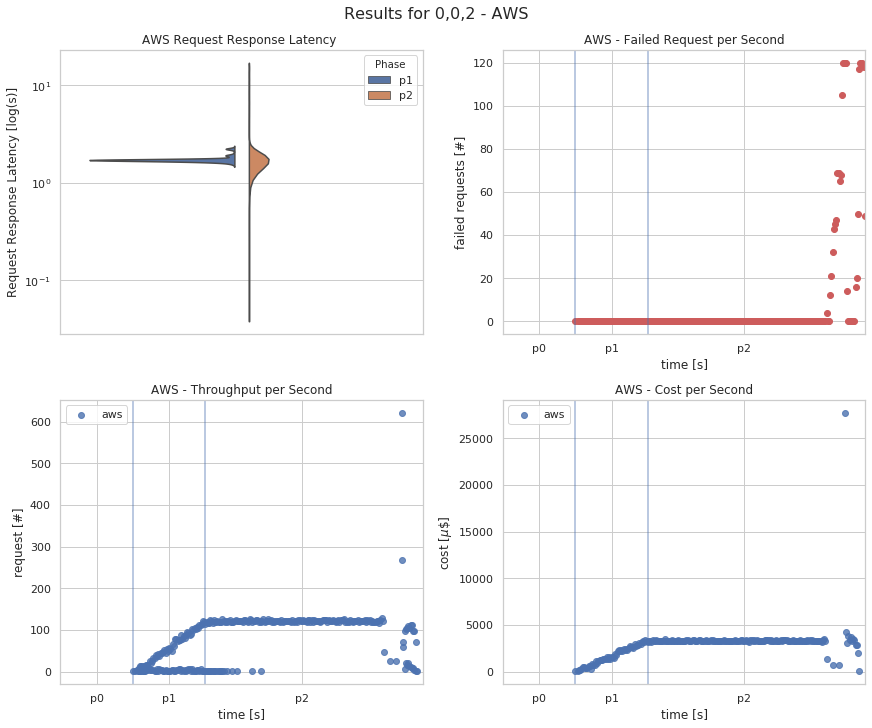

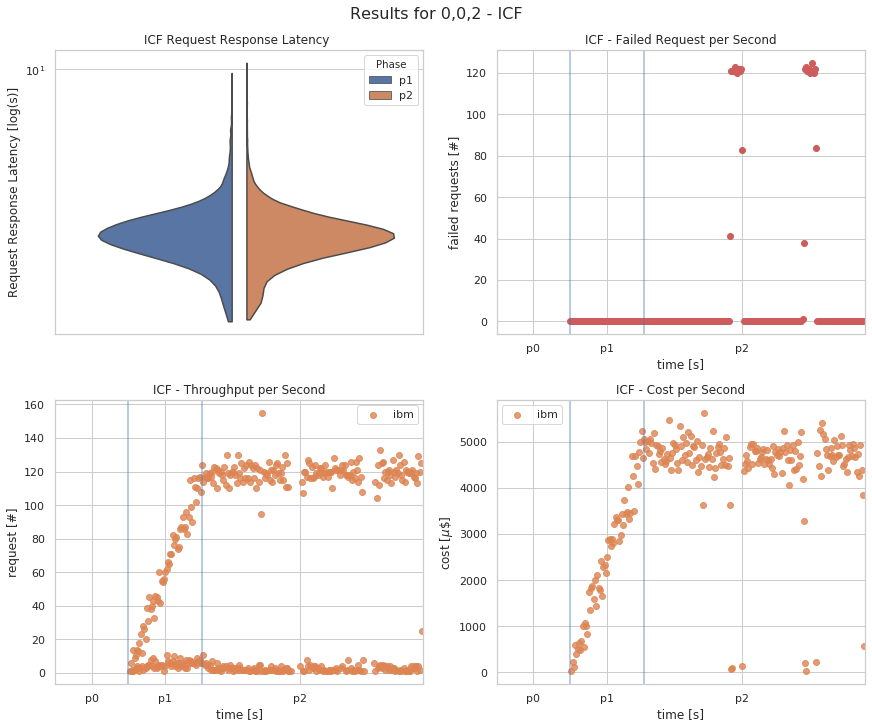

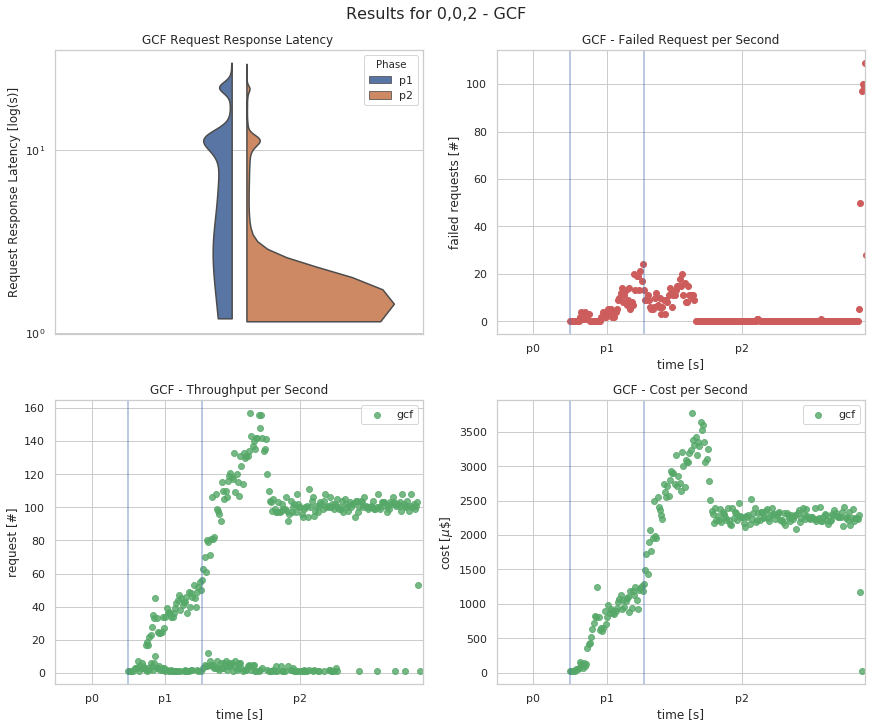

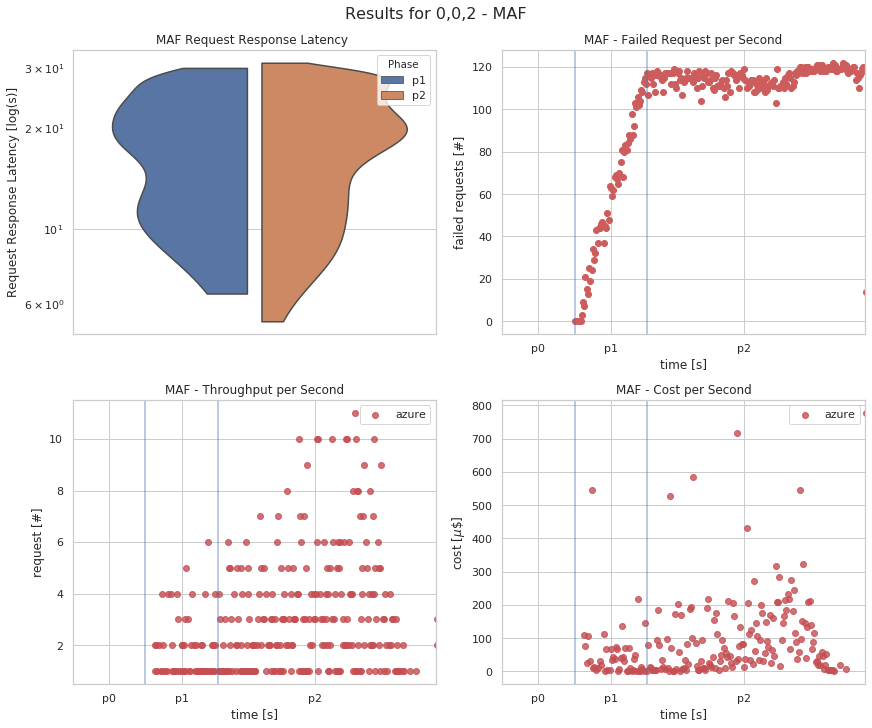

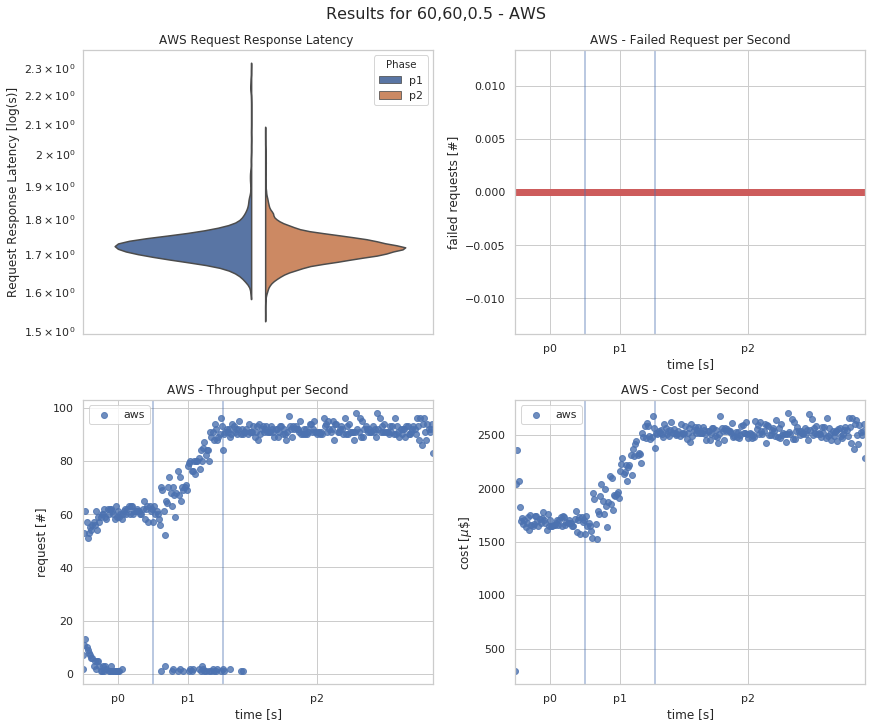

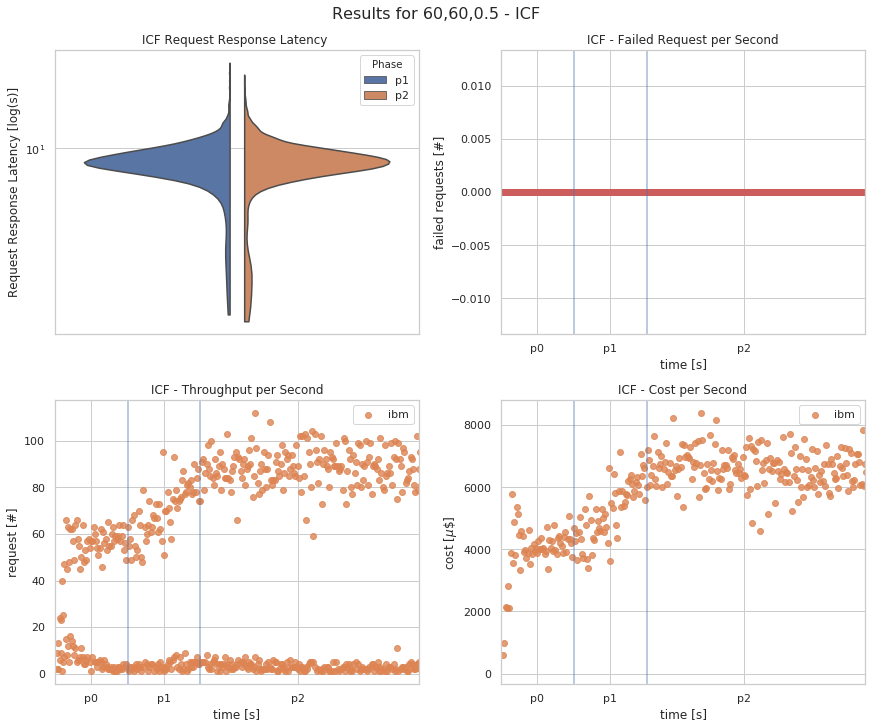

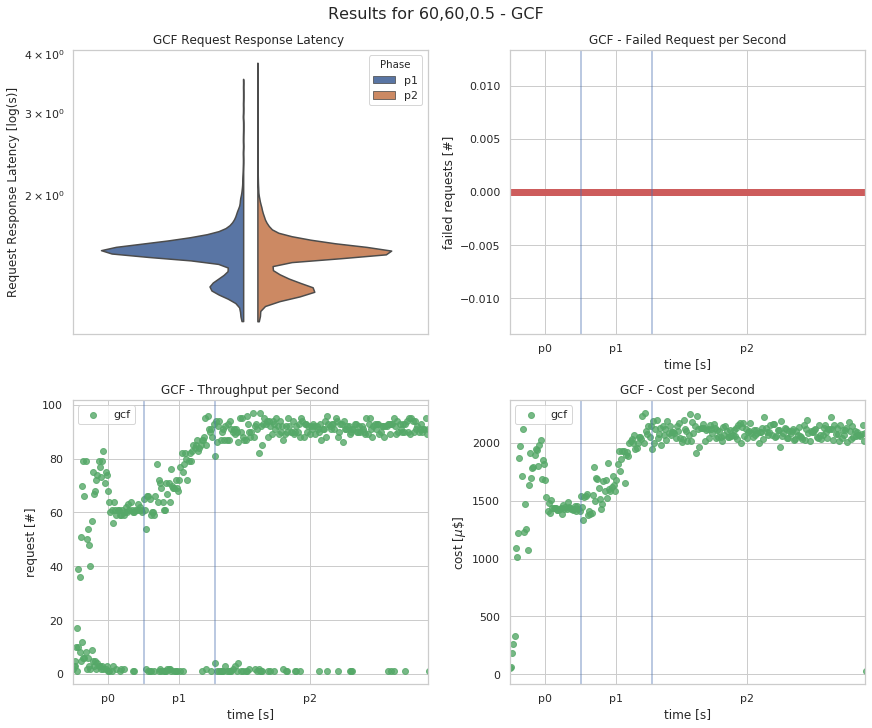

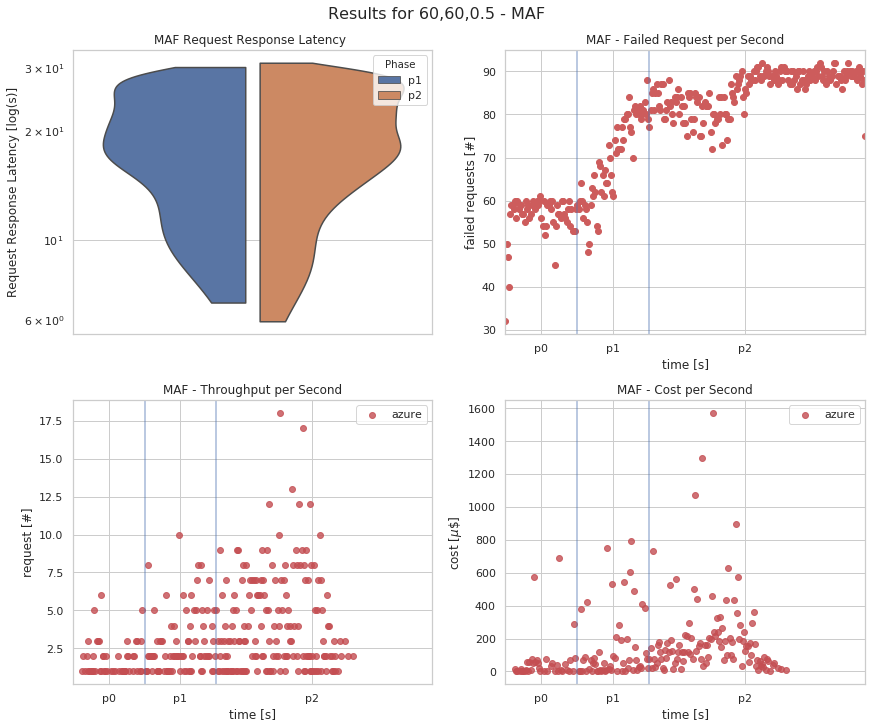

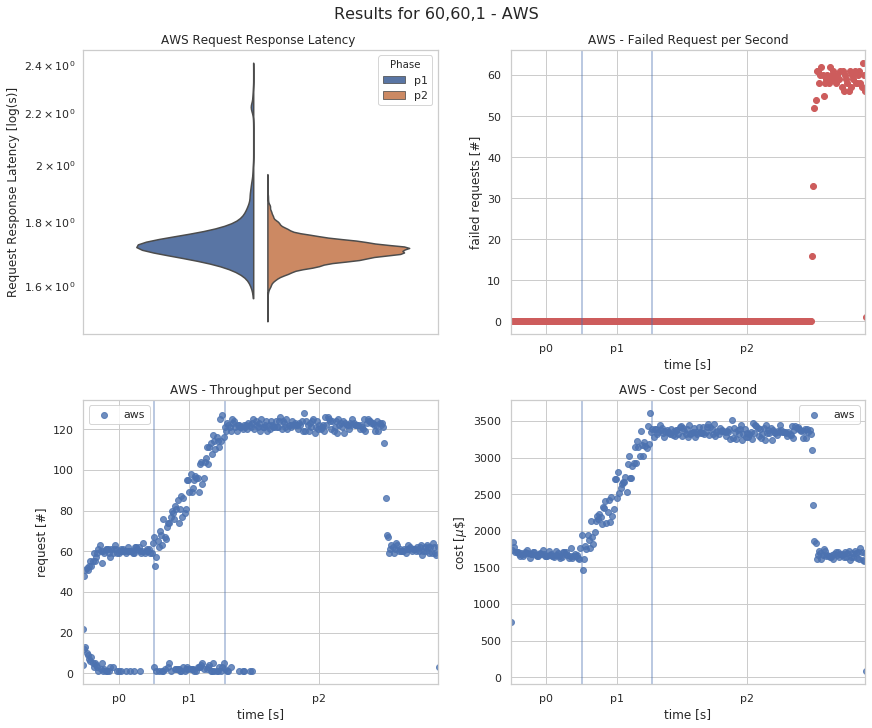

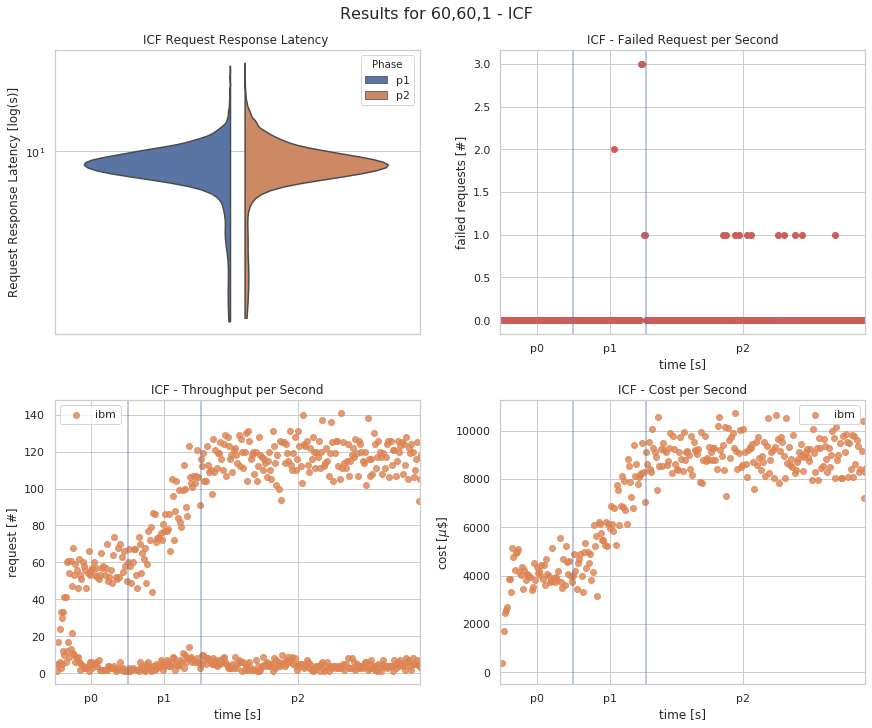

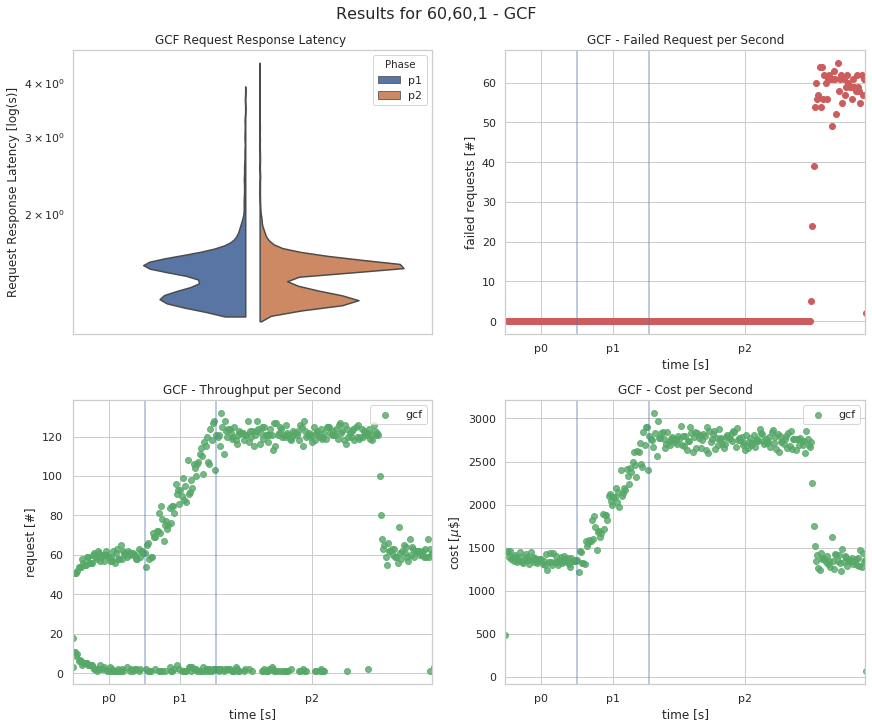

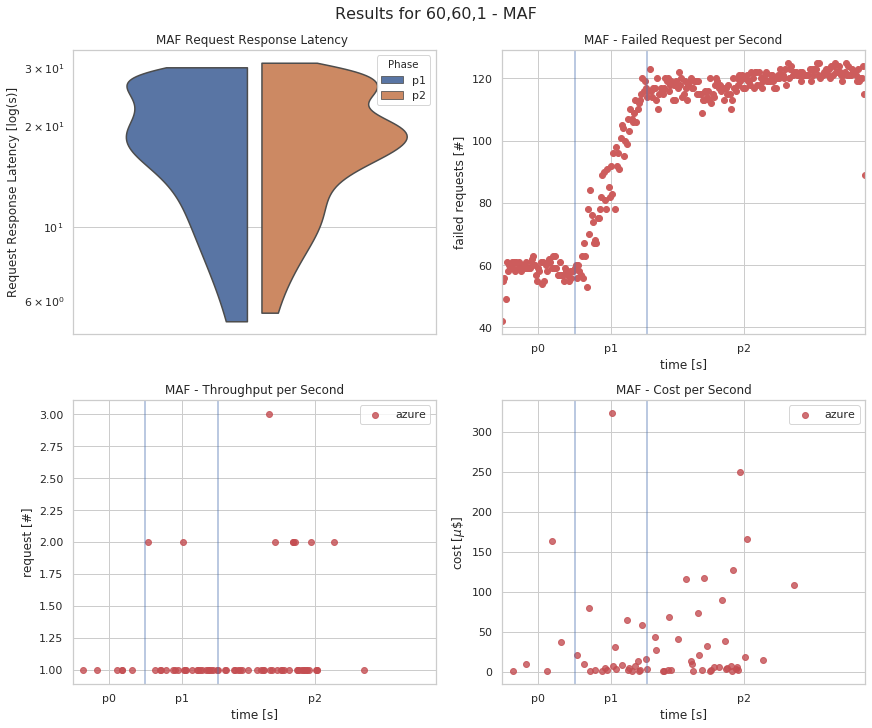

In [52]:
from matplotlib.gridspec import GridSpec
for workload in configs:
    for provider in providers:
        fig = plt.figure(constrained_layout=True,figsize=(12,10))
        gs = GridSpec(2, 2, figure=fig)
        plt.suptitle("Results for {} - {}".format(workload,style[provider]["name"]), fontsize=16)
        ax = fig.add_subplot(gs[0, 0])
        plotRequestResponseViolin(ax,all,provider,workload)
        ax = fig.add_subplot(gs[0, 1])
        plotFailedRequestPerSecond(ax,all,provider,workload)
        ax = fig.add_subplot(gs[1, 0])
        thruputPerSecond(ax,all,provider,workload)
        ax = fig.add_subplot(gs[1, 1])
        costPerSecond(ax,all,provider,workload)

In [ ]:

def plotLatencyBand(ax,data,group,lat,label="Latency",interval=1000):
    g = group+"_"+lat+"_"+str(interval)
    data[g] = round(data[group]/interval)
    lats = data.groupby([g])[lat].agg([np.mean,np.max,np.min]).reset_index()
    sns.lineplot(x=g, y='mean', data=lats,ax=ax,label=label)
    ax.fill_between(x=g,y1="amax",y2="amin",data=lats,alpha=0.5)

    
def plotWorkload(ax,data,time,label="Workload",interval=1000):
    g = time+"_WL_"+str(interval)
    data[g] = round(data[time]/interval)
    lats = data.groupby([g])['RId'].count().reset_index(name="workload")
    sns.lineplot(x=g, y='workload', data=lats, color="gray",label=label,ax=ax2)    



In [ ]:
#prep data
data = all.copy()

data['RStart_1s'] = round(data["RStart"]/1000)
data['REnd_1s'] = round(data["REnd"]/1000)

data = data[data["Phase"].isin(["p0","p1","p2"])]
#preselect
fig,axs = plt.subplots(5,figsize=(16,18), dpi= 80)
idx = 0
for workload in configs:
    ax = axs[idx]
    for provider in providers:
        ax.set_title("delta Thruput {}".format(workload))
        tmp = data[(data["Provider"]==provider)&(data["WL"]==workload)]
        started_requests = tmp.groupby("RStart_1s")["RId"].count().reset_index(name="y")
        started_requests = started_requests["y"].ewm(span=30)
        #started_requests.mean().plot(style = 'tab:red')


        finished_requests = tmp.groupby("REnd_1s")["RId"].count().reset_index(name="y")
        finished_requests = finished_requests["y"].ewm(span=30)
        delta_thr = (finished_requests.mean()-started_requests.mean())
        if workload[0] == "0":
            delta_thr = np.pad(delta_thr,(60,0),'constant')
        delta_thr = delta_thr[0:300]
        sns.lineplot(y=delta_thr,x=range(0,len(delta_thr)),ax=ax,label=provider)
    ax.axvline(60)
    ax.axvline(120)
    ax.set_ylim([-20,20])
    ax.legend()
    idx+=1

#plt.plot("RStart_1s","y",data=started_requests,color="tab:red")
# tmp = data[(data["Provider"]==provider)&(data["WL"]==workload)]
# finished_requests = tmp.groupby("REnd_1s")["RId"].count().reset_index(name="y")



In [ ]:
fig,ax = plt.subplots()
plt.title("delta Thruput {}".format(workload))
tmp = data[(data["Provider"]==provider)&(data["WL"]==workload)]
started_requests = tmp.groupby("RStart_1s")["RId"].count().reset_index(name="y")
started_requests = started_requests["y"].ewm(span=30)
#started_requests.mean().plot(style = 'tab:red')


finished_requests = tmp.groupby("REnd_1s")["RId"].count().reset_index(name="y")
finished_requests = finished_requests["y"].ewm(span=30)
delta_thr = (finished_requests.mean()-started_requests.mean())
sns.lineplot(y=delta_thr,x=range(0,len(delta_thr)),ax=ax)

In [ ]:
run = 1
workloads = all['WL'].unique()
providers = all['Provider'].unique()
from matplotlib.gridspec import GridSpec

positions = {"aws":(0,0),"gcf":(1,0),"ibm":(0,1),"azure":(1,1)}

for WL in workloads:
    fig = plt.figure(constrained_layout=True,figsize=(14,10))
    gs = GridSpec(2, 2, figure=fig)
    plt.suptitle("Request Response Latency - Execution Latency [%s]"%(WL), fontsize=16)
    idx=0
    for provider in providers:
        data = all[(all['WL'] == WL) & (all['Provider'] == provider) & (all['run'] == run)]
        data = data.copy()
        pos = positions[provider]
        
        plotLatencyBand(ax,data,'RStart','RLat',"Request Response Latency")
        plotLatencyBand(ax,data,'EStart','ELat',"Exectution Latency")
        ax2 = ax.twinx()
        plotWorkload(ax2,data,'RStart')
        
        ax.set_xlabel("time [s]")
        ax.set_ylabel("latency [ms]")
        ax.set_title(provider)
        ax.legend(["Request Response Latency", "Execution Latency","workload"], loc='upper left')
        ax.set_xlim([0,299])
        ax.set_ylim([0,12000])
        idx+=1

    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
